Pandas library will be used to manipulate the raw data to dataframe and graphings later on. To read a parquet extension file using pandas, we have to download pyarrow in advanced.

In [283]:
import pandas as pd

df_price = pd.read_parquet('/Users/DericoDehnielsen/Downloads/price.snappy.parquet')
df_item = pd.read_parquet('/Users/DericoDehnielsen/Downloads/item.snappy.parquet')
df_feedback = pd.read_parquet('/Users/DericoDehnielsen/Downloads/feedback.snappy.parquet')

I have decided to only take into consideration the item_id that are present in the feedback dataset as a valid transaction. First, I will convert unix timestamp to datetime for easier grouping and get the count of each item_id for each date.

In [284]:
import datetime as dt

l = df_feedback.shape[0]

for i in range(l):
    df_feedback.loc[i,'feedback_time'] = dt.datetime.date(pd.Timestamp(df_feedback.loc[i,'feedback_time'], unit='s'))

In [285]:
df_feedback.drop('feedback_rating',axis=1)
df_feedback.drop('feedback_hash',axis=1)
feedback = df_feedback.groupby(['feedback_time','item_id']).size().reset_index(name='count')
feedback.rename(columns={'feedback_time':'date'},inplace=True)
feedback.head()

,date,item_id,count
0,1970-01-01,5864d22336,1
1,1970-01-01,5882294fac,1
2,1970-01-01,6d8f1af238,1
3,1970-01-01,95b7c9f032,4
4,2011-05-23,1478736c39,1


Check whether all items in the feedback dataset are present in the price dataset.

In [305]:
print(feedback.shape)
print(feedback['item_id'].isin(df_price['item_id']).value_counts())

(96567, 3)
True    96567
Name: item_id, dtype: int64


Now, I will merge the feedback dataframe with the df_price dataframe to have the price together with the transaction date in one dataframe. Thus, I will use left merge where the left dataset is the feedback data. However, because some items have different price tag at different times, I decided to get the average price of each item as they do not fluctuate a lot.

I could have used the exact price per date, but I decided to go with the average because converting the unix timestamp to datetime takes too long (have waited for more than 2 hours on my laptop but still have not finished).

In [306]:
price_mean = df_price.groupby('item_id').mean()
price_mean.shape

(24390, 2)

Next, I calculated the total amount paid for an item id for each date and get the volume per date in btc.

In [307]:
transactions = pd.merge(feedback, price_mean, on=['item_id'], how='left')
transactions['volume_btc'] = transactions['count']*transactions['price']
transactions = transactions.drop(['count','price','item_id'],axis=1)
transactions = new_transactions.groupby('date').sum()
transactions = transactions.iloc[1:,:] #the first row is from the year 1970, so I discard it
transactions.head()

,volume (btc)
date,
2011-05-23,252.745375
2011-06-08,10.043000
2011-06-14,10.330000
2011-06-16,19.520435
2011-06-21,80.251500


The dataset below is extracted from investing.com. It is the exchange rate of BTC to USD.
Link: https://www.investing.com/crypto/bitcoin/historical-data

In [308]:
df_btc = pd.read_csv('/Users/DericoDehnielsen/Downloads/Bitcoin Historical Data - Investing.com.csv')
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_btc.set_index('Date',inplace=True)
df_btc = df_btc['Price']
df_btc.head()

Date
2012-07-24    8.6
2012-07-23    8.4
2012-07-22    8.4
2012-07-21    8.9
2012-07-20    8.5
Name: Price, dtype: float64

Merge the df_btc dataframe and transactions dataframe together.

In [309]:
transactions = transactions.join(df_btc)

In [310]:
transactions.rename(columns={'Price':'exchange rate'},inplace=True)
transactions['volume (usd)'] = transactions['volume (btc)'] * transactions['exchange rate']

In [311]:
transactions.head()

,volume (btc),exchange rate,volume (usd)
date,,,
2011-05-23,252.745375,7.2,1819.766698
2011-06-08,10.043000,29.6,297.272800
2011-06-14,10.330000,19.3,199.369000
2011-06-16,19.520435,17.0,331.847391
2011-06-21,80.251500,17.5,1404.401250


To get the transactions volume each day, I can sum the 'count' data per date from the feedback dataframe earlier.

In [312]:
transaction_volume = feedback.groupby('date').sum()
transactions = transactions.join(transaction_volume)

In [313]:
transactions.rename(columns={'volume (btc)': 'volume_btc', 'exchange rate': 'exchange_rate','volume (usd)': 'volume_usd', 'count': 'transaction_volume'},inplace=True)

This is my final dataset for this assignment:

In [317]:
transactions

,volume_btc,exchange_rate,volume_usd,transaction_volume
date,,,,
2011-05-23,252.745375,7.2,1819.766698,8
2011-06-08,10.043000,29.6,297.272800,1
2011-06-14,10.330000,19.3,199.369000,1
2011-06-16,19.520435,17.0,331.847391,1
2011-06-21,80.251500,17.5,1404.401250,3
...,...,...,...,...
2012-07-20,15792.157993,8.5,134233.342937,1056
2012-07-21,9830.860486,8.9,87494.658328,809
2012-07-22,2893.629646,8.4,24306.489027,213


Text(0.5, 0, 'Date')

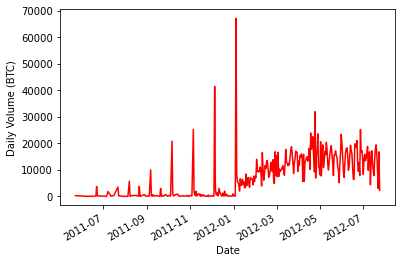

In [315]:
import matplotlib.pyplot as plt

transactions['volume_btc'].plot(kind='line',
                               color='r')

plt.ylabel('Daily Volume (BTC)')
plt.xlabel('Date')

Export transactions dataset to csv file

In [321]:
tr = transactions.to_csv('transactions.csv',index=True)